In [1]:
import os
import cv2
import random
import math
import PIL.Image as Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
import scipy.ndimage as ndi
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iris Biometric Identification

##### Segmentation and Recognition

## Vasil Kichukov

## Abstract


__What is Iris Biometric Identification?__

Iris biometric identification uses the unique patterns in the colored part of the eye (the iris) to identify individuals. Even the left and right irises of a person are unique. This method is highly secure and reliable, as no two people have the same iris patterns, making it one of the most accurate forms of biometric identification.

__Why is This Project Important?__

This project is important because iris recognition provides one of the most accurate ways to identify people. By developing a system that can segment the iris from the surrounding eye region, we can make the recognition process more precise and faster, which is crucial for secure applications.

__How Can This Be Used in Business?__

Iris recognition can be used in various industries for secure access, identity verification, and fraud prevention. It can improve security for businesses, banking, healthcare, and even in mobile devices, allowing for seamless and secure user experiences.

__What is the Purpose of This Project?__

The purpose of this project is to create a reliable system for accurately segmenting the iris from the eye using deep learning techniques. After segmentation, the project also focuses on recognizing the individual by comparing their segmented iris patterns to a database, allowing for secure identification and authentication. This process is essential for ensuring that the model can not only isolate the iris but also verify the identity of the person, which is crucial for applications like access control and secure transactions.

## Table of Contents

TODO

## Introduction

Iris biometric identification offers one of the most secure and accurate methods of recognizing individuals, as each person’s iris patterns are unique. Unlike other biometric traits, the iris remains stable throughout life and is extremely difficult to replicate, making it ideal for high-security applications such as banking, government, and healthcare.


Iris recognition systems are increasingly integrated into various sectors, from border control to mobile devices. These systems are growing in use due to their high accuracy and reliability. However, challenges like accurate segmentation of the iris, varying lighting conditions, and different eye shapes remain, which complicate large-scale deployment. With advancements in AI and machine learning, iris recognition technology is expected to improve in both speed and accuracy. As security needs continue to rise, iris biometric systems will likely play a critical role in personal identification and secure access in the future.

## Dataset Representation

The datasets used in this project are __IITD__ and __CASIA 1000__, which provide a rich collection of iris images for biometric identification tasks.

The __IITD dataset__ (Indian Eye Iris Dataset) was developed by the Indian Institute of Technology Delhi (IITD). It contains a total of __2240 RGB iris images__ collected from 224 individuals, with 10 images per subject. Each image in the dataset is of the size 320x240 pixels, maintaining an __aspect ratio of 4:3__. The corresponding masks for this dataset, which are used for iris segmentation, were obtained from a GitHub repository, and I would like to express my gratitude to the creators of IITD for providing the images and permission to use them for my research purposes. The images are initially in RGB format, but for this project, I converted them to grayscale to simplify processing.

The __CASIA 1000__ dataset was downloaded from Kaggle and is another significant resource for iris recognition. It contains __20,000 grayscale iris images__ from 1000 subjects, with each subject contributing 20 images — 10 images from their left eye and 10 from their right eye. The images in this dataset have a resolution of 640x480 pixels, with an __aspect ratio of 4:3__. The CASIA 1000 dataset offers a diverse set of iris images that will be invaluable for testing and validating the segmentation and recognition models.

While the images in IITD are of smaller resolution, CASIA 1000 offers a larger and more varied collection, ensuring robust model training and evaluation. The IITD dataset is primarily used in this project to create segmentation masks for the main CASIA dataset, enabling effective segmentation of the irises from the CASIA images. These segmentation masks will be crucial in training the models for iris recognition, ensuring high accuracy and reliability in real-world applications. Both datasets play a critical role in this project, enabling the development and testing of advanced segmentation and recognition algorithms for biometric iris identification.

## Iris Segmentation

In [2]:
BASE_IMAGE_DIR = "data_masks/IITD_dataset"
BASE_MASK_DIR  = "data_masks/IITD_masks"
SAVE_DIR = "./data"
HEIGHT = 240
WIDTH = 320
CHANNELS = 1
ASPECT_RATIO = WIDTH/HEIGHT
SIZE = (WIDTH, HEIGHT)
SIZE_CHANNELS = (WIDTH, HEIGHT, CHANNELS)
BATCH_SIZE = 8
EPOCHS = 24

To reduce hardcoding, we'll keep everything in different variables so we can manipulate it more easily if needed.

### Reading and visualizations

In [3]:
def check_image_dimensions_dir(directory, expected_size, expected_channels):
    incorrect_dimensions = []
    
    if expected_channels == 1:
        expected_mode = 'L'
    elif expected_channels == 3:
        expected_mode = 'RGB'
    else:
        expected_mode = None
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.bmp', '.tiff',)):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        actual_size = img.size
                        actual_mode = img.mode
                        if actual_size != expected_size or (expected_mode and actual_mode != expected_mode):
                            incorrect_dimensions.append((image_path, actual_size, actual_mode))
                except Exception as e:
                    incorrect_dimensions.append((image_path, "Error", str(e)))
                    
    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} images with incorrect dimensions {directory}.")
        for i, (file_path, size, mode) in enumerate(incorrect_dimensions[:4]):
            print(f"{file_path} -> size: {size}, mode: {mode}")
    else:
        print(f"All images in {directory} have correct dimensions and mode.")

print("Checking BASE_IMAGE_DIR:")
check_image_dimensions_dir(BASE_IMAGE_DIR, expected_size=SIZE, expected_channels=CHANNELS)
print("\nChecking BASE_MASK_DIR:")
check_image_dimensions_dir(BASE_MASK_DIR, expected_size=SIZE, expected_channels=CHANNELS)

Checking BASE_IMAGE_DIR:
2240 images with incorrect dimensions data_masks/IITD_dataset.
data_masks/IITD_dataset\001\01.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\02.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\03.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\04.bmp -> size: (320, 240), mode: RGB

Checking BASE_MASK_DIR:
All images in data_masks/IITD_masks have correct dimensions and mode.


The function checks whether all the images in a specified folder and its subfolders match the expected size and color channels. It loops through all images in the directory, opens them, and compares their size and mode (grayscale or RGB) with the expected values. If any images have incorrect dimensions or modes, they are listed, and the function prints the first 4 such images along with their size and mode details. If all images are correct, it simply prints a message confirming that everything is fine.

In [169]:
def map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR):
    image_to_mask_map = {}

    for folder_id in range(1, 225):
        folder_str = f"{folder_id:03d}"
        image_folder_path = os.path.join(BASE_IMAGE_DIR, folder_str)
        
        for i in range(1, 11):
            image_index_str = f"{i:02d}"
            image_filename = f"{image_index_str}.bmp"
            full_image_path = os.path.join(image_folder_path, image_filename)
            mask_filename = f"{folder_str}_{image_index_str}.tiff"
            full_mask_path = os.path.join(BASE_MASK_DIR, mask_filename)
            
            if os.path.exists(full_image_path) and os.path.exists(full_mask_path):
                image_to_mask_map[full_image_path] = full_mask_path
            else:
                print(f"Missing file(s): {full_image_path} or {full_mask_path}")
    
    return image_to_mask_map

image_to_mask_map = map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR)


print("\nFirst 5 (image -> mask) pairs:")
for idx, (img_path, mask_path) in enumerate(image_to_mask_map.items()):
    print(f"{idx+1}. {img_path} -> {mask_path}")
    if idx == 4:
        break


First 5 (image -> mask) pairs:
1. data_masks/IITD_dataset\001\01.bmp -> data_masks/IITD_masks\001_01.tiff
2. data_masks/IITD_dataset\001\02.bmp -> data_masks/IITD_masks\001_02.tiff
3. data_masks/IITD_dataset\001\03.bmp -> data_masks/IITD_masks\001_03.tiff
4. data_masks/IITD_dataset\001\04.bmp -> data_masks/IITD_masks\001_04.tiff
5. data_masks/IITD_dataset\001\05.bmp -> data_masks/IITD_masks\001_05.tiff


We create a dictionary that links image file paths to their corresponding mask file paths. It loops through the image and mask directories, checks if the files exist, and maps each image to its mask. The function returns the dictionary containing all valid image-mask pairs.

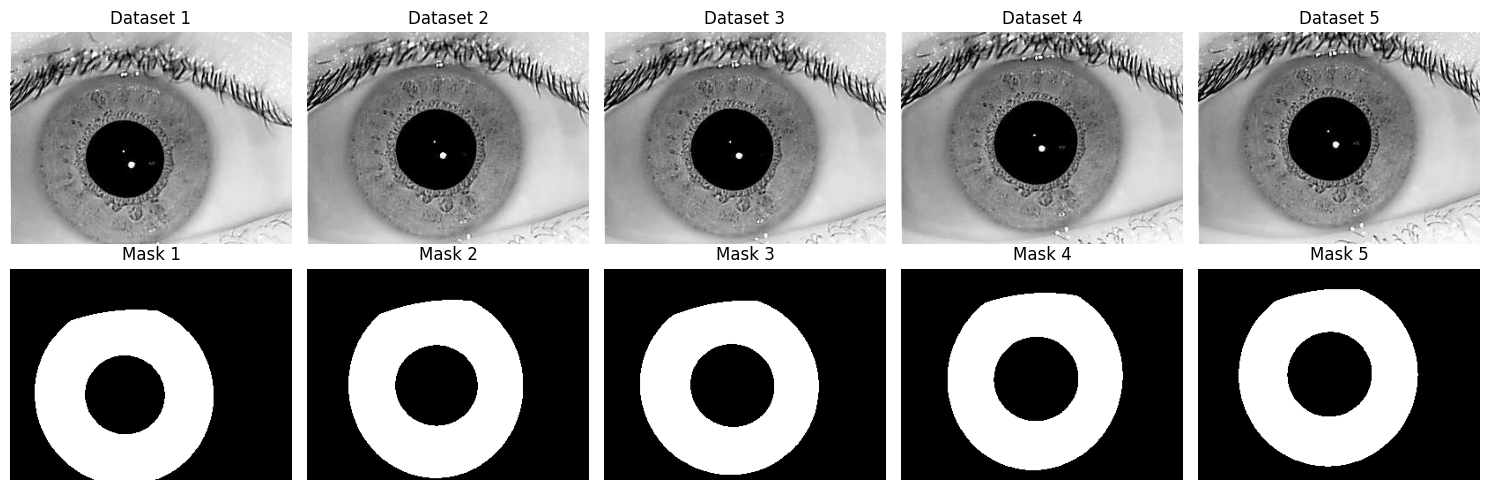

In [170]:
def visualize_images_from_dict(image_to_mask_map, num_images=5):
    selected_pairs = list(image_to_mask_map.items())[:num_images]
    plt.figure(figsize=(15, 5))  
    
    for i, (img_path, mask_path) in enumerate(selected_pairs):
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Dataset {i+1}")
        plt.axis('off')
        
        mask_img = Image.open(mask_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_from_dict(image_to_mask_map, num_images=5)

## Preprocessing

In [171]:
def split_dataset(image_to_mask_map, train_ratio=0.8):
    pairs = list(image_to_mask_map.items())
    random.shuffle(pairs)
    split_idx = int(train_ratio * len(pairs))
    
    train_pairs = pairs[:split_idx]
    val_pairs   = pairs[split_idx:]
    
    return train_pairs, val_pairs

train_pairs, val_pairs = split_dataset(image_to_mask_map, train_ratio=0.8)

# Optionally print the split sizes to check
print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")


Train pairs: 1792
Validation pairs: 448


We split the dataset of image-mask pairs into training and validation sets based on the specified train_ratio. It first shuffles the image-mask pairs to ensure a random split, then divides the shuffled pairs into two sets: one for training and the other for validation. The training set contains train_ratio (default 80%) of the total pairs, and the remaining pairs are allocated to the validation set. The function returns the two sets: train_pairs and val_pairs

In [172]:
def load_image_mask(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img_norm = (img.astype(np.float32)) / 255.0
    msk_bin = (msk > 127).astype(np.float32)
    
    # Expand dims: (240,320) -> (240,320,1)
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin,  axis=-1)
    
    return img_norm, msk_bin

The function loads an image and its corresponding mask from the specified file paths. Although the image files are originally in RGB format, the function reads them as grayscale using OpenCV. The image is then normalized to the range [0, 1] by dividing its pixel values by 255, and the mask is binarized by setting pixels above a threshold of 127 to 1 (foreground) and below to 0 (background). After processing, both the image and the mask are expanded to have an extra dimension (making them 3D arrays, i.e., (height, width, 1)) to match the input shape required by the model. The function then returns the transformed grayscale image and its corresponding mask.

In [173]:
def data_generator(pairs_list, batch_size=BATCH_SIZE):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i : i+batch_size]
            
            images = []
            masks  = []
            
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask(img_path, msk_path)
                images.append(img_arr)
                masks.append(msk_arr)
            
            images = np.array(images, dtype=np.float32)  # shape=(B,240,320,1)
            masks  = np.array(masks,  dtype=np.float32)  # shape=(B,240,320,1)
            
            yield (images, masks)

Generator yields batches of image-mask pairs for training a model. It continuously loops through the provided list of image-mask pairs (pairs_list), shuffles them, and splits them into batches of a specified size (batch_size). For each batch, it loads the corresponding images and masks using the load_image_mask function, processes them into grayscale format, normalizes the images, and binarizes the masks. The images and masks are then converted to NumPy arrays with a shape of (batch_size, height, width, 1) to match the model's input requirements. The function yields these batches of processed images and masks indefinitely for training.

## U-net - custom model

In [175]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

The Dice coefficient is used for segmentation because it effectively measures the overlap between the predicted mask and the ground truth mask. Unlike accuracy, which can be misleading in cases of imbalanced datasets, the Dice coefficient focuses on how well the model captures the iris area by comparing the true positive pixels in both the predicted and actual masks.

In [174]:
def get_early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2, 
        restore_best_weights=True
    )

EarlyStopping callback monitors the validation loss during training. If the validation loss doesn't improve for 2 consecutive epochs (patience=2), training stops early and the best model weights are restored.

In [176]:
def create_unet(input_shape=(240,320,1)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)

    # Upsampling
    u4 = layers.UpSampling2D((2,2))(c3)
    concat4 = layers.concatenate([u4, c2], axis=-1)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(concat4)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2,2))(c4)
    concat5 = layers.concatenate([u5, c1], axis=-1)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(concat5)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    # Output layer: 1 channel with sigmoid
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

The __U-Net architecture__ is a popular model for image segmentation tasks. It consists of two main parts: downsampling (contracting path) and upsampling (expansive path).

__Downsampling__ (Contracting Path): This part extracts features from the input image using convolutional layers with ReLU activation and max-pooling layers for downsampling. It captures spatial hierarchies of the image.

The first convolution block (c1) has two convolutional layers with 32 filters, followed by a max-pooling operation.
The second block (c2) uses 64 filters and also follows the same pattern.
The third block (c3) has 128 filters and serves as the bottleneck of the network, where the most abstract features are captured.

__Upsampling__ (Expansive Path): This part rebuilds the segmented output using up-sampling layers followed by convolutions. It combines the features from earlier layers using skip connections (concatenation) to preserve high-resolution details. U4 and u5 are upsampling layers, each followed by convolution blocks (c4, c5) to refine the segmentation.

Output Layer: The final layer produces a single channel output (grayscale), using a sigmoid activation for pixel-wise classification (foreground or background). The sigmoid activation ensures that the model outputs a probability map, where values closer to 1 represent foreground (iris) and values closer to 0 represent the background.

In [177]:
# Assuming `data_generator`, `train_pairs`, `val_pairs`, `BATCH_SIZE`, and `dice_metric` are defined elsewhere
train_gen = data_generator(train_pairs, batch_size=BATCH_SIZE)
val_gen = data_generator(val_pairs, batch_size=BATCH_SIZE)

# Create U-Net model
model = create_unet(input_shape=(240, 320, 1))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_metric]
)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 240, 320, 1)]        0         []                            
                                                                                                  
 conv2d_218 (Conv2D)         (None, 240, 320, 32)         320       ['input_15[0][0]']            
                                                                                                  
 conv2d_219 (Conv2D)         (None, 240, 320, 32)         9248      ['conv2d_218[0][0]']          
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 120, 160, 32)         0         ['conv2d_219[0][0]']          
 ng2D)                                                                                     

The model is compiled using the Adam optimizer, which adapts the learning rate based on training, and the binary cross-entropy loss function, suitable for binary segmentation tasks (iris vs. background).

In [178]:
steps_per_epoch  = len(train_pairs) // BATCH_SIZE
validation_steps = len(val_pairs)   // BATCH_SIZE

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=get_early_stopping_callback()
)

Epoch 1/24
224/224 [==============================] - 561s 2s/step - loss: 0.2901 - dice_metric: 0.6581 - val_loss: 0.1822 - val_dice_metric: 0.8482
Epoch 2/24
224/224 [==============================] - 540s 2s/step - loss: 0.1184 - dice_metric: 0.8859 - val_loss: 0.0953 - val_dice_metric: 0.9147
Epoch 3/24
224/224 [==============================] - 539s 2s/step - loss: 0.0839 - dice_metric: 0.9195 - val_loss: 0.1159 - val_dice_metric: 0.8910
Epoch 4/24
224/224 [==============================] - 536s 2s/step - loss: 0.0751 - dice_metric: 0.9280 - val_loss: 0.0650 - val_dice_metric: 0.9383
Epoch 5/24
224/224 [==============================] - 555s 2s/step - loss: 0.0646 - dice_metric: 0.9374 - val_loss: 0.0657 - val_dice_metric: 0.9384
Epoch 6/24
224/224 [==============================] - 557s 2s/step - loss: 0.0628 - dice_metric: 0.9394 - val_loss: 0.0644 - val_dice_metric: 0.9420
Epoch 7/24
224/224 [==============================] - 555s 2s/step - loss: 0.0562 - dice_metric: 0.9455 - 

The training shows steady progress in both loss reduction and improvement in segmentation quality. The model is learning effectively on the training set while maintaining a good generalization to the validation set. 

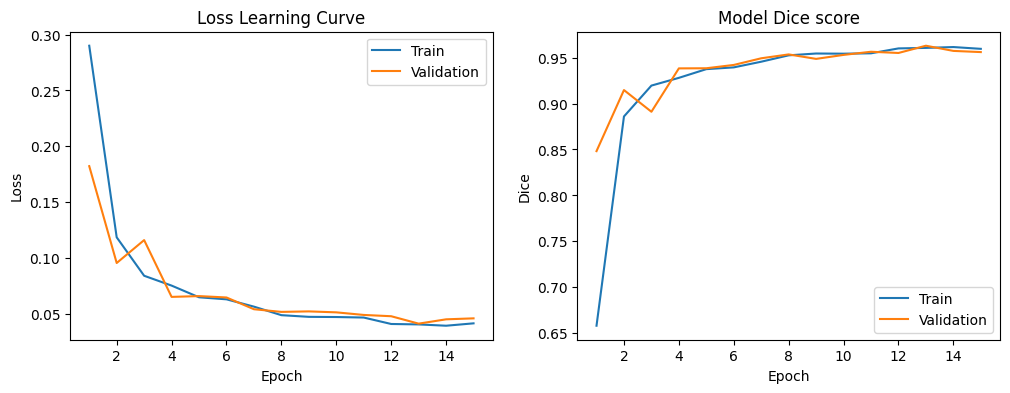

In [180]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss   = history.history['val_loss']
    
    train_dice = history.history['dice_metric']
    val_dice   = history.history['val_dice_metric']
    
    epochs_range = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.title('Loss Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_dice, label='Train')
    plt.plot(epochs_range, val_dice, label='Validation')
    plt.title('Model Dice score')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

plot_learning_curves(history)

__Overfitting__: There isn't a clear sign of overfitting, as the training and validation curves are fairly close. However, some fluctuations in the validation loss and Dice score suggest that the model might slightly overfit towards the end of training. The validation dice is close to training dice, which means the model is generalizing well to unseen data. The slight fluctuation (val_dice_metric dropped) suggests a bit of noise.

__Convergence__: Both the loss and Dice metrics are leveling out after around 10 epochs, which indicates that the model has likely reached its optimal performance on the given data. Further epochs will not result in improvements.

__Model Performance__: The model's ability to segment the iris seems to be strong, with a validation Dice score approaching 0.95 and a validation loss that's quite low, suggesting good segmentation performance on unseen data.

In [181]:
def create_overlay(original_path, pred_mask, alpha=0.4):
    pred_mask = pred_mask.squeeze(axis=-1)

    orig = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    orig_color = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    
    green_mask = np.zeros_like(orig_color)
    green_mask[...,1] = (pred_mask * 255).astype(np.uint8)

    overlay = cv2.addWeighted(orig_color, 1.0, green_mask, alpha, 0)
    return overlay

We create an image overlay where the predicted mask is displayed on top of the original image. It first reads the original image and converts it to a color format. Then, it creates a green mask from the predicted mask and overlays it on the original image with a specified transparency (alpha). The resulting image shows the original iris image with the predicted mask highlighted in green.

Found 1 poorly segmented images (dice < 0.7):
data_masks/IITD_dataset\003\01.bmp => dice=0.358


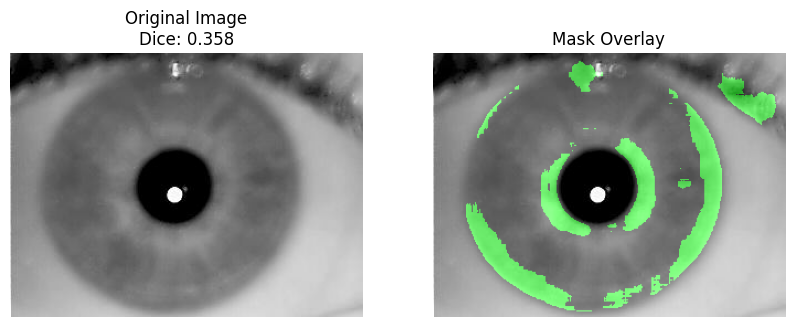

In [183]:
def evaluate_segmentation_per_image(pairs_list, model, threshold=0.5, dice_threshold=0.7):
    poorly_segmented = []
    
    for (img_path, msk_path) in pairs_list:
        img_arr, msk_arr = load_image_mask(img_path, msk_path)

        pred = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        pred_2d = pred[0, ..., 0]  
        pred_bin = (pred_2d > threshold).astype(np.float32)

        y_true_f = msk_arr.flatten()
        y_pred_f = pred_bin.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

        if dice < dice_threshold:
            poorly_segmented.append((img_path, dice, pred_bin))

    if poorly_segmented:
        print(f"Found {len(poorly_segmented)} poorly segmented images (dice < {dice_threshold}):")

        for img_path, dice_val, pred_mask in poorly_segmented:
            print(f"{img_path} => dice={dice_val:.3f}")

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            pred_mask_for_overlay = cv2.resize(
                pred_mask, 
                (img.shape[1], img.shape[0]),  # (width, height) in OpenCV
                interpolation=cv2.INTER_NEAREST
            )

            green_mask = np.zeros_like(img_color)
            green_mask[..., 1] = (pred_mask_for_overlay * 255).astype(np.uint8)

            overlay = cv2.addWeighted(img_color, 1.0, green_mask, 0.5, 0)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img_color, cmap='gray')
            plt.title(f"Original Image\nDice: {dice_val:.3f}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.title("Mask Overlay")
            plt.axis('off')

            plt.show()
    else:
        print("All images have a higher score than the dice threshold.")


poorly_segmented_images = evaluate_segmentation_per_image(val_pairs, model, threshold=0.5, dice_threshold=0.70)

The function checks each image's Dice score. If the score is below the specified threshold (default 0.7), the image is considered poorly segmented. The function prints the image path, Dice score, and displays an overlay of the predicted mask on the original image for inspection. Only one image had a low Dice score of 0.358, and it will display the overlay for review.

In [248]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, "seg_model.h5")
model.save(model_path)
print(f"The segmentation model has been successfully saved as 'seg_model.h5' in the folder '{SAVE_DIR}'.")

The segmentation model has been successfully saved as 'seg_model.h5' in the folder './data'.


C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### U-net - Implementation from a Paper

In [236]:
IMG_HEIGHT = 576
IMG_WIDTH = 576
BATCH_SIZE = 4

In [237]:
def load_image_mask_same(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    msk_resized = cv2.resize(msk, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    img_norm = img_resized.astype(np.float32) / 255.0
    msk_bin  = (msk_resized > 127).astype(np.float32)

    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin,  axis=-1)

    return img_norm, msk_bin

In [238]:
def data_generator_same(pairs_list, batch_size=BATCH_SIZE, augment=True):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i : i+batch_size]
            images = []
            masks  = []

            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask_same(img_path, msk_path)
                
                if augment:
                    img_arr, msk_arr = augment_image_and_mask(img_arr, msk_arr)
                
                images.append(img_arr)
                masks.append(msk_arr)

            images = np.array(images, dtype=np.float32)
            masks  = np.array(masks,  dtype=np.float32)

            yield (images, masks)

In [239]:
class CropToMatch(layers.Layer):
    def call(self, inputs):
        source, target = inputs
        s = tf.shape(source)
        t = tf.shape(target)

        height_diff = s[1] - t[1]
        width_diff  = s[2] - t[2]

        crop_top  = height_diff // 2
        crop_left = width_diff  // 2

        return tf.slice(
            source,
            [0, crop_top, crop_left, 0],
            [-1, s[1] - crop_top*2, s[2] - crop_left*2, -1]
        )

In [240]:
def random_elastic_deformation(image, mask, alpha=10, sigma=3, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape[:2]
    dx = ndi.gaussian_filter(
        (random_state.rand(*shape) * 2 - 1),
        sigma,
        mode="constant",
        cval=0
    ) * alpha
    dy = ndi.gaussian_filter(
        (random_state.rand(*shape) * 2 - 1),
        sigma,
        mode="constant",
        cval=0
    ) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

    def _map_coords(img_2d):
        return ndi.map_coordinates(img_2d, indices, order=1, mode='reflect').reshape(shape)

    deformed_img  = _map_coords(image[:,:,0])
    deformed_mask = ndi.map_coordinates(mask[:,:,0], indices, order=0, mode='reflect').reshape(shape)

    deformed_img  = np.expand_dims(deformed_img,  axis=-1)
    deformed_mask = np.expand_dims(deformed_mask, axis=-1)
    return deformed_img, deformed_mask

def augment_image_and_mask(img, msk, do_flip=True, do_elastic=True):
    if do_flip and np.random.rand() < 0.5:
        img = np.flip(img, axis=1)
        msk = np.flip(msk, axis=1)

    if do_elastic:
        img, msk = random_elastic_deformation(img, msk, alpha=10, sigma=3)

    return img, msk

In [241]:
def unet_same(
    input_shape=(576, 576, 1),
    num_classes=1,
    initial_filters=64,
    final_activation='sigmoid'
):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u6 = layers.Conv2DTranspose(initial_filters*8, (2,2), strides=2, kernel_initializer='he_normal')(c5)
    merge6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(initial_filters*4, (2,2), strides=2, kernel_initializer='he_normal')(c6)
    merge7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(initial_filters*2, (2,2), strides=2, kernel_initializer='he_normal')(c7)
    merge8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(initial_filters, (2,2), strides=2, kernel_initializer='he_normal')(c8)
    merge9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(num_classes, (1,1), activation=final_activation)(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [242]:
def train_unet_same(
    train_pairs, val_pairs,
    steps_per_epoch, validation_steps,
    epochs=EPOCHS,
    optimizer_params=None,
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=None,
    plot_model_diagram=False
):
    if metrics is None:
        metrics = [dice_metric]

    model = unet_same(
        input_shape=(576, 576, 1),
        num_classes=num_classes,
        final_activation=final_activation
    )
    
    print("---- Model Summary ----")
    model.summary()

    if plot_model_diagram:
        tf.keras.utils.plot_model(
            model,
            to_file='unet_architecture.png',
            show_shapes=True,
            show_layer_names=True
        )
        print("Model diagram saved as 'unet_architecture.png'")

    if optimizer_params is None:
        optimizer_params = {'learning_rate':1e-4}  
    optimizer = tf.keras.optimizers.Adam(**optimizer_params)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    train_gen = data_generator_same(train_pairs, batch_size=BATCH_SIZE, augment=True)
    val_gen   = data_generator_same(val_pairs,   batch_size=BATCH_SIZE, augment=False)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[get_early_stopping_callback()]
    )

    return model, history

In [243]:
STEPS_PER_EPOCH  = len(train_pairs) // BATCH_SIZE
VALIDATION_STEPS = len(val_pairs)   // BATCH_SIZE

model_same, history_same = train_unet_same(
    train_pairs, val_pairs,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    optimizer_params={'learning_rate':1e-4},
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=[dice_metric],
    plot_model_diagram=False
)

---- Model Summary ----
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 576, 576, 1)]        0         []                            
                                                                                                  
 conv2d_334 (Conv2D)         (None, 576, 576, 64)         640       ['input_22[0][0]']            
                                                                                                  
 conv2d_335 (Conv2D)         (None, 576, 576, 64)         36928     ['conv2d_334[0][0]']          
                                                                                                  
 max_pooling2d_70 (MaxPooli  (None, 288, 288, 64)         0         ['conv2d_335[0][0]']          
 ng2D)                                                             

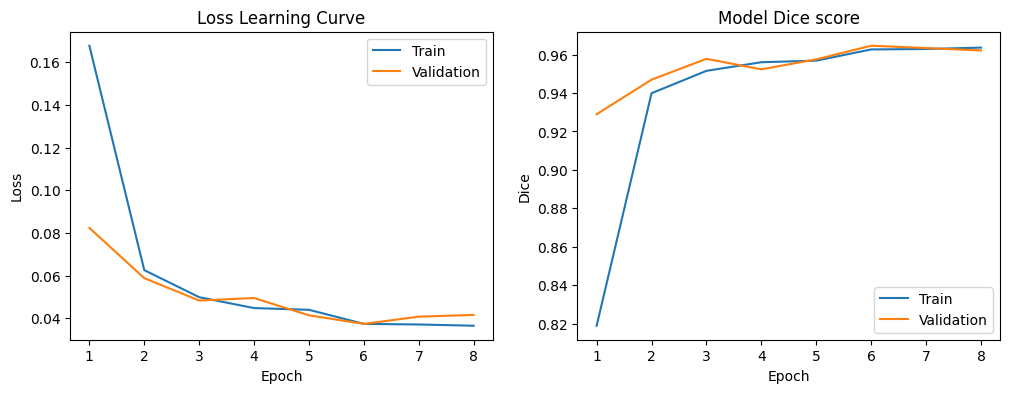

In [244]:
plot_learning_curves(history_same)

In [245]:
poorly_segmented_images = evaluate_segmentation_per_image(
    val_pairs, model_same, threshold=0.5, dice_threshold=0.70
)

All images have a higher score than the dice threshold.


In [249]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_same_path = os.path.join(SAVE_DIR, "seg_model_same.h5")
model_same.save(model_same_path)
print(f"The second segmentation model has been saved as 'seg_model_same.h5' in the folder '{SAVE_DIR}'.")

The second segmentation model has been saved as 'seg_model_same.h5' in the folder './data'.


While the models perform well on the IITD dataset, they struggle to generalize to the CASIA 1000 dataset, likely due to overfitting and the differences in image quality, lighting, and reflections. Unfortunately, due to time constraints, further development to address these issues will be reserved for future work. However, the proposed improvements, adding noise, regularization(dropout), and training on a more diverse dataset, are promising directions for enhancing the model's robustness and generalization capabilities.

## Iris Recognition

In [4]:
CSV_FILE = "./data/iris_thousands.csv"
PUPIL_DATASET_DIR = ".//data/pupil_dataset"
PUPIL_PRED_DATASET_DIR = ".//data/pupil_dataset_pred"
ORIGINAL_CASIA_DIR = "./data/CASIA-Iris-Thousand/"
SAVE_CASIA_BMP_DIR  = "./data/CASIA_BMP/"
SAVE_MASKS_1_DIR = "./data/CASIA_generated_masks_1/"
MODEL_1_PATH = "./data/seg_model.h5"
SAVE_MASKS_2_DIR = "./data/CASIA_generated_masks_2/"
MODEL_2_PATH = "./data/seg_model_same.h5"
NUM_CLASSES = 2000
IMAGE_WIDTH = 640    
IMAGE_HEIGHT = 480
IMAGE_CHANNELS = 1
TARGET_SIZE = (320, 240)
TARGET_SIZE_2 = (576, 576)
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

### Reading and visualizations

In [5]:
iris_data = pd.read_csv(CSV_FILE)
check_image_dimensions_dir(ORIGINAL_CASIA_DIR, expected_size=IMAGE_SIZE, expected_channels=IMAGE_CHANNELS)

All images in ./data/CASIA-Iris-Thousand/ have correct dimensions and mode.


In [6]:
def check_class_distribution(dataset):
    class_counts = dataset['Label'].value_counts()
    if class_counts.min() != class_counts.max():
        print("Class distribution is imbalanced.")
    else:
        print("Class distribution is balanced.")

check_class_distribution(iris_data)

Class distribution is balanced.


In [7]:
def update_paths(iris_df, base_dir, target_column):
    corrected_paths = []
    missing_files = []

    for index, row in iris_df.iterrows():
        label = row['Label']
        image_filename = os.path.basename(row['ImagePath'])
        subject_id, eye = label.split("-")

        corrected_path = os.path.join(base_dir, subject_id, eye, image_filename)

        if not os.path.exists(corrected_path):
            alternative_ext = ".bmp" if image_filename.lower().endswith(".jpg") else ".jpg"
            corrected_path_alt = os.path.splitext(corrected_path)[0] + alternative_ext

            if os.path.exists(corrected_path_alt):
                corrected_path = corrected_path_alt
            else:
                missing_files.append(corrected_path)

        corrected_paths.append(corrected_path)

    iris_df[target_column] = corrected_paths

    if not missing_files:
        print("✅ All image paths are valid and exist in the dataset directory.")
    else:
        print(f"⚠️ {len(missing_files)} missing image(s) found:")
        for file in missing_files[:5]:
            print(file)

    return iris_df 

In [9]:
iris_data = update_paths(iris_data, ORIGINAL_CASIA_DIR, "OriginalPath")
iris_data.head(4)

✅ All image paths are valid and exist in the dataset directory.


,Unnamed: 0,Label,ImagePath,OriginalPath
0,0,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg
1,1,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg
2,2,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg
3,3,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg


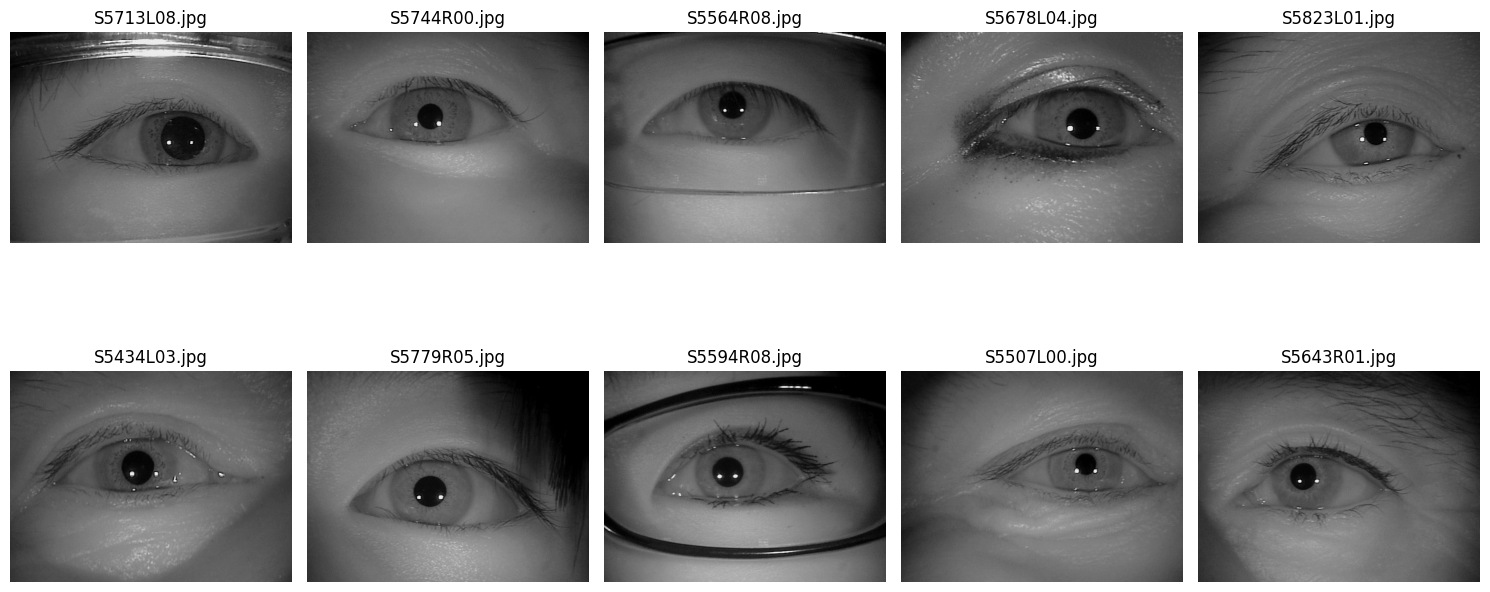

In [10]:
def visualize_images(dataset, column_name, num_images):
    sample_images = dataset.sample(num_images)[column_name].tolist()
    plt.figure(figsize=(15, 8))
    
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        if IMAGE_CHANNELS == 1:
            img = img.convert("L")
        
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img, cmap="gray" if IMAGE_CHANNELS == 1 else None)
        plt.title(os.path.basename(image_path))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_images(iris_data, "OriginalPath", num_images=10)

### Generating masks

In [10]:
def convert_casia_jpg_to_bmp(csv_file, original_base_dir, save_base_dir):
    casia_image_paths = iris_data["OriginalPath"].tolist()
    os.makedirs(save_base_dir, exist_ok=True)
    bmp_paths = []
    
    for img_path in casia_image_paths:
        relative_path = os.path.relpath(img_path, original_base_dir)
        bmp_path = os.path.join(save_base_dir, relative_path.replace(".jpg", ".bmp"))
        os.makedirs(os.path.dirname(bmp_path), exist_ok=True)
        img = cv2.imread(img_path)
        cv2.imwrite(bmp_path, img)
        bmp_paths.append(bmp_path)

    print(f"All CASIA JPG images converted to BMP and saved in '{save_base_dir}'")
    return bmp_paths

##casia_bmp_paths = convert_casia_jpg_to_bmp(CSV_FILE, ORIGINAL_CASIA_DIR, SAVE_CASIA_BMP_DIR)

In [11]:
iris_data = update_paths(iris_data, SAVE_CASIA_BMP_DIR, "WorkPath")

✅ All image paths are valid and exist in the dataset directory.


In [12]:
iris_data = iris_data.drop(columns=["Unnamed: 0", "ImagePath"])

In [13]:
iris_data.head(4)

,Label,OriginalPath,WorkPath
0,437-R,./data/CASIA_BMP/437\R\S5437R06.bmp,./data/CASIA_BMP/437\R\S5437R06.bmp
1,437-R,./data/CASIA_BMP/437\R\S5437R09.bmp,./data/CASIA_BMP/437\R\S5437R09.bmp
2,437-R,./data/CASIA_BMP/437\R\S5437R07.bmp,./data/CASIA_BMP/437\R\S5437R07.bmp
3,437-R,./data/CASIA_BMP/437\R\S5437R02.bmp,./data/CASIA_BMP/437\R\S5437R02.bmp


In [14]:
def preprocess_casia_bmp(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, TARGET_SIZE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    
    return img

In [15]:
def generate_mask(image_path, save_path, model):
    img = preprocess_casia_bmp(image_path)
    img_batch = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_batch, verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255

    cv2.imwrite(save_path, pred_mask)

In [16]:
def generate_all_masks(bmp_image_paths, save_mask_dir, model):
    os.makedirs(save_mask_dir, exist_ok=True)

    for img_path in bmp_image_paths:
        img_name = os.path.basename(img_path).replace(".bmp", ".tiff")
        mask_save_path = os.path.join(save_mask_dir, img_name)

        generate_mask(img_path, mask_save_path, model)

    print(f"All CASIA masks saved in '{save_mask_dir}'")

In [18]:
##seg_model_1 = tf.keras.models.load_model(MODEL_1_PATH, compile=False)
##generate_all_masks(casia_bmp_paths, SAVE_MASKS_1_DIR, seg_model_1)

Second mask

In [17]:
def preprocess_casia_bmp_same(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, TARGET_SIZE_2, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    
    return img

In [18]:
def apply_augmentations(img):
    do_flip = np.random.rand() < 0.5
    do_elastic = True

    return augment_image_and_mask(img, img, do_flip=do_flip, do_elastic=do_elastic)[0]

In [19]:
def generate_mask_same(image_path, save_path, model):
    img = preprocess_casia_bmp_same(image_path)
    img = apply_augmentations(img)
    img_batch = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_batch, verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255 

    cv2.imwrite(save_path, pred_mask)

In [20]:
def generate_all_masks_same(bmp_image_paths, save_mask_dir, model):
    os.makedirs(save_mask_dir, exist_ok=True)

    for img_path in bmp_image_paths:
        img_name = os.path.basename(img_path).replace(".bmp", ".tiff")
        mask_save_path = os.path.join(save_mask_dir, img_name)

        generate_mask_same(img_path, mask_save_path, model)

    print(f"All CASIA masks saved in '{save_mask_dir}'")

In [21]:
## seg_model_2 = tf.keras.models.load_model(MODEL_2_PATH, compile=False)
## generate_all_masks_same(casia_bmp_paths, SAVE_MASKS_2_DIR, seg_model_2)

# Pupil Detection (Iris Inner Boundary)

In [28]:
def refine_circle_by_intensity(image, circle, intensity_range, step=2):
    x, y, r = circle
    h, w = image.shape
    refined_r = r

    for i in range(-step, step + 1):
        temp_r = r + i
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (x, y), temp_r, 1, thickness=1)
        band_pixels = image[mask == 1]

        if np.mean(band_pixels) >= intensity_range[0] and np.mean(band_pixels) <= intensity_range[1]:
            refined_r = temp_r
    return (x, y, refined_r)

Adjusts the radius of a detected pupil circle by checking the pixel intensity within the circle. It tests different radii within a specified range and selects the one where the average intensity falls within the given range. The function returns the refined circle with the best fitting radius.

In [29]:
def detect_pupil(image, param1=80, param2=30, min_radius=20, max_radius=80):
    gray = cv2.GaussianBlur(image, (7, 7), 0)
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=param1, param2=param2, 
        minRadius=min_radius, maxRadius=max_radius
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0, 0]
        refined_circle = refine_circle_by_intensity(gray, (x, y, r), intensity_range=(0, 70))
        return refined_circle
    return None

Detecting the pupil in an image using the Hough Circle Transform. It applies a Gaussian blur to the image and then uses cv2.HoughCircles to detect circles that may correspond to the pupil. If a circle is detected, the function refines the radius of the circle based on the pixel intensity inside the circle using the refine_circle_by_intensity function. The function returns the refined circle (x, y, r) if a pupil is detected, or None if no pupil is found.

In [30]:
def save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path):
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    cv2.circle(output_image, (pupil_x, pupil_y), pupil_r, (0, 255, 0), 2)
    cv2.circle(output_image, (pupil_x, pupil_y), 2, (0, 0, 255), 3)

    save_path = os.path.join(PUPIL_DATASET_DIR, os.path.basename(img_path))
    cv2.imwrite(save_path, output_image)

We save an image with the detected pupil highlighted. It first converts the grayscale image to color, then draws a green circle around the detected pupil and a red dot at the center. The image is saved in the pupil_dataset directory with the same name as the original image. This function is useful for reviewing and validating the accuracy of pupil detection results.

In [31]:
def detect_and_store_pupils(image_paths):
    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        pupil = detect_pupil(image)
        if pupil is not None:
            pupil_x, pupil_y, pupil_r = pupil
            save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path)

    print(f"Pupil images saved in: {PUPIL_DATASET_DIR}")
    
os.makedirs(PUPIL_DATASET_DIR, exist_ok=True)
casia_jpg_paths = iris_data["OriginalPath"].tolist()
detect_and_store_pupils(casia_jpg_paths)

✅ Pupil images saved in: .//data/pupil_dataset


All detected pupils are stored in the pupil_dataset folder and prepared for manual review. The algorithm detected 19,241(from 20,000) after manual inspection another 288 were deleted so in total our correctly segmented pupils are __18,953 or 94.75% of all images__.

In [33]:
def process_pupils():
    iris_data["PupilPath"] = ""  
    iris_data["pupil_x"] = None  
    iris_data["pupil_y"] = None  
    iris_data["pupil_radius"] = None 
    iris_data["pupil_detected"] = 0  

    for index, row in iris_data.iterrows():
        img_filename = os.path.basename(row["OriginalPath"])
        img_path = os.path.join(PUPIL_DATASET_DIR, img_filename)

        if os.path.exists(img_path): 
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            pupil = detect_pupil(image)

            if pupil is not None:
                pupil_x, pupil_y, pupil_r = pupil
                iris_data.at[index, "PupilPath"] = img_path
                iris_data.at[index, "pupil_detected"] = 1
                iris_data.at[index, "pupil_x"] = pupil_x
                iris_data.at[index, "pupil_y"] = pupil_y
                iris_data.at[index, "pupil_radius"] = pupil_r

    print(f"Iris dataset updated")

process_pupils()

Iris dataset updated


Checks if the pupil detection exists in the PUPIL_DATASET_DIR for each image. If the pupil is detected, it updates the dataset with the pupil's coordinates (pupil_x, pupil_y), radius (pupil_radius) and if the pupil was detected (pupil_detected)

In [34]:
iris_data.head(4)

,Unnamed: 0,Label,ImagePath,OriginalPath,PupilPath,pupil_x,pupil_y,pupil_radius,pupil_detected
0,0,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg,,None,None,None,0
1,1,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg,.//data/pupil_dataset\S5437R09.jpg,308,168,38,1
2,2,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg,.//data/pupil_dataset\S5437R07.jpg,330,172,36,1
3,3,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg,.//data/pupil_dataset\S5437R02.jpg,336,246,32,1


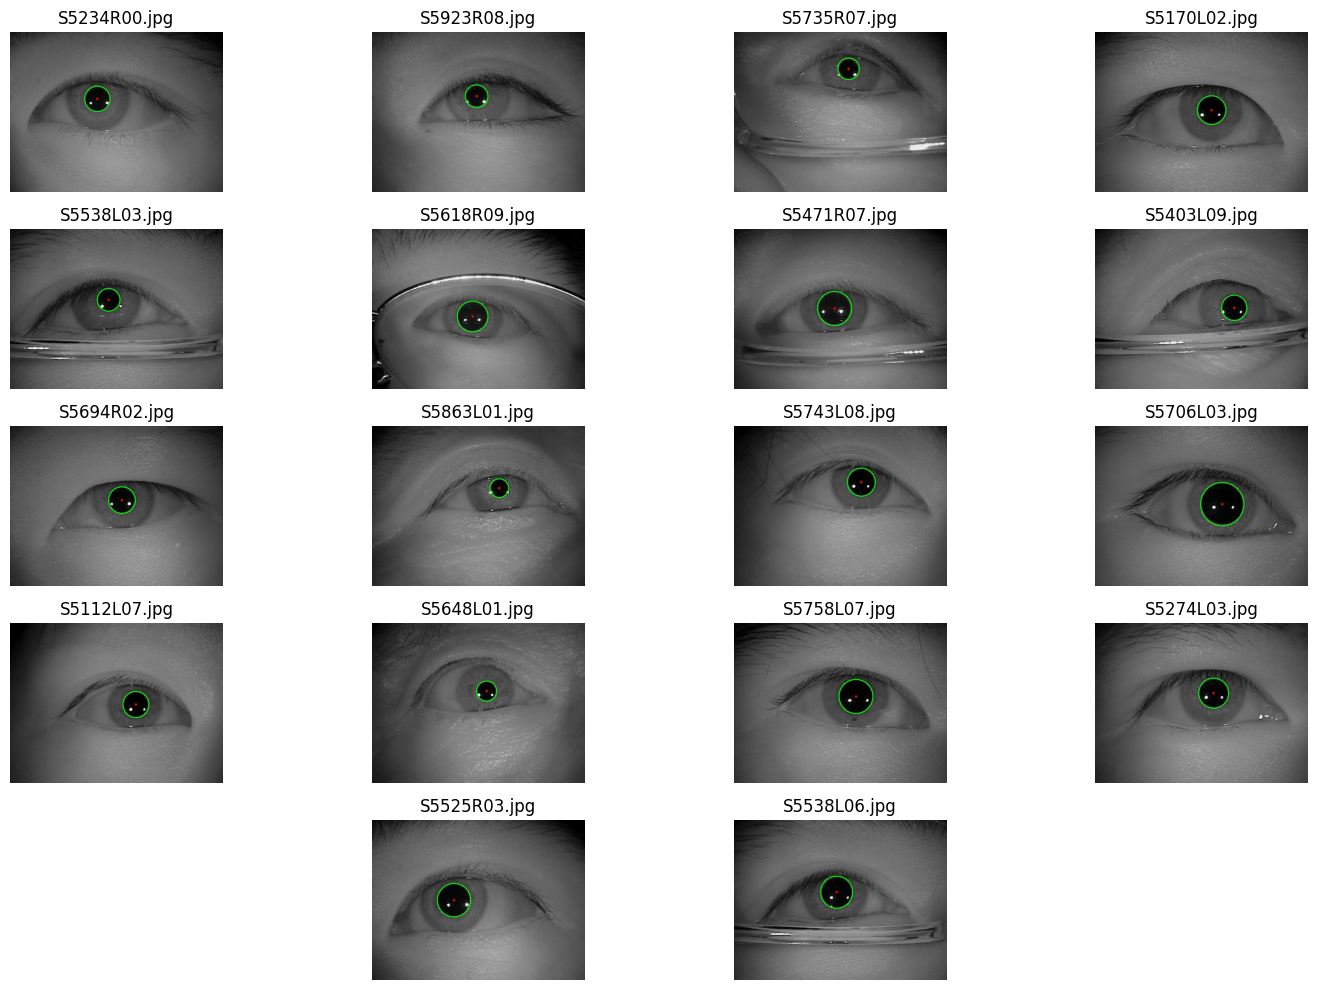

In [35]:
def visualize_pupils():
    valid_images = iris_data[iris_data["PupilPath"].notnull()]
    random_images = random.sample(list(valid_images.iterrows()), 20)
    plt.figure(figsize=(15, 10))

    for i, (index, row) in enumerate(random_images):
        img_path = row["PupilPath"]

        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(5, 4, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(os.path.basename(img_path))
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_pupils()

In [ ]:
PUPIL_EPOCH = 6
PUPIL_BATCH = 32
PUPIL_STEPS_PER_EPOCH = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.85 / PUPIL_BATCH)
PUPIL_VALIDATION_STEPS = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.15 / PUPIL_BATCH)

#Splitting the data into 85% for training and 15% for validation

The pupil implementation below is based on the paper "An integrated neural network model for pupil detection and tracking – Lu Shi, ChangYuan Wang, Feng Tian, Hongbo Jia" (https://eprints.bournemouth.ac.uk/35772/1/LVCF_prepublish.pdf). The proposed approach, referred to as the VCF model, combines two key components:

__V-Net__: A modified encoder–decoder network that extracts multi-scale features from the input image through successive downsampling and upsampling, with skip connections to retain fine details.

__CF (Coordinate-Final) Block__: Inspired by object detection methods like YOLO, this block divides the image into a grid and predicts the pupil parameters (x and y offsets, and radius) for the grid cell that contains the pupil center, along with a confidence score indicating responsibility.

In [37]:
def custom_pupil_loss(y_true, y_pred):

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    r_true = y_true[..., 2]
    resp_true = y_true[..., 3]
    
    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    r_pred = y_pred[..., 2]
    conf_pred = y_pred[..., 3]
    
    # Loss weights.
    lambda_coord = 5.0
    lambda_noobj = 0.5
    
    # Coordinate and radius loss (only for responsible cells).
    coord_loss = lambda_coord * resp_true * ((x_true - x_pred) ** 2 + (y_true_ - y_pred_) ** 2)
    radius_loss = lambda_coord * resp_true * ((r_true - r_pred) ** 2)
    
    # Confidence loss.
    conf_loss = resp_true * (1 - conf_pred) ** 2 + lambda_noobj * (1 - resp_true) * (conf_pred) ** 2
    
    total_loss = coord_loss + radius_loss + conf_loss
    return tf.reduce_mean(total_loss)

The custom loss function calculates the loss for pupil detection by comparing the true and predicted values for the pupil’s center coordinates, radius, and confidence. It applies a weighted loss depending on whether the cell is responsible for detecting the pupil or not. This helps the model focus on learning the correct position and size of the pupil, while also avoiding false positives. The total loss is a combination of the coordinate loss, radius loss, and confidence loss.

In [46]:
def pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640), grid_size=(7, 10), r_max=64, shuffle=True):
    df = iris_data[iris_data['pupil_detected'] == 1].copy().reset_index(drop=True)
    indices = np.arange(len(df))
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            X_batch = []
            Y_batch = []
            
            grid_rows, grid_cols = grid_size
            img_h, img_w = image_size
            cell_h = img_h / grid_rows
            cell_w = img_w / grid_cols
            
            for i in batch_indices:
                row = df.iloc[i]
                img_path = row["OriginalPath"]
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.resize(image, (img_w, img_h))

                pupil_x = float(row['pupil_x'])
                pupil_y = float(row['pupil_y'])
                pupil_r = float(row['pupil_radius'])
                
                cell_row = int(pupil_y // cell_h)
                cell_col = int(pupil_x // cell_w)
                cell_row = min(cell_row, grid_rows - 1)
                cell_col = min(cell_col, grid_cols - 1)
                
                x_offset = (pupil_x - (cell_col * cell_w)) / cell_w
                y_offset = (pupil_y - (cell_row * cell_h)) / cell_h
                r_scaled = pupil_r / r_max

                target = np.zeros((grid_rows, grid_cols, 4), dtype=np.float32)
                target[cell_row, cell_col, :] = [x_offset, y_offset, r_scaled, 1.0]
                
                X_batch.append(image)
                Y_batch.append(target)
                            
            yield np.array(X_batch), np.array(Y_batch)

In [47]:
train_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                                 grid_size=(7, 10), r_max=64, shuffle=True)
val_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                               grid_size=(7, 10), r_max=64, shuffle=False)

This function takes a list of images and their pupil locations and generates batches for training the model. For each image, it divides the image into a grid and calculates where the pupil is located within that grid. It then generates a target grid with information about the pupil's position and radius. This allows the neural network to learn where the pupil is in each image. The function shuffles the data and processes it in batches for efficient training.

In [48]:
def center_mae_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    error = tf.abs(y_true[..., 0:2] - y_pred[..., 0:2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates how far off the predicted pupil center coordinates (x, y) are from the true coordinates, but only for the cells where a pupil exists (indicated by the mask). The result is the MAE for the center prediction, showing how well the model is doing in detecting the pupil's position.

In [49]:
def radius_mae_metric(y_true, y_pred):
    mask = y_true[..., 3]
    error = tf.abs(y_true[..., 2] - y_pred[..., 2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates the mean absolute error (MAE) between the predicted and actual pupil radius, but only for the cells where a pupil exists (indicated by the mask).

In [50]:
def euclidean_center_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    true_xy = y_true[..., 0:2] * mask
    pred_xy = y_pred[..., 0:2] * mask
    true_center = tf.reduce_sum(true_xy, axis=[1, 2])
    pred_center = tf.reduce_sum(pred_xy, axis=[1, 2])
    diff = true_center - pred_center
    dist = tf.sqrt(tf.reduce_sum(diff ** 2, axis=-1))
    return tf.reduce_mean(dist)

Euclidean distance between the true and predicted positions of the pupil center, considering only areas where the pupil is detected. The smaller the distance, the better the model has detected the correct pupil center. 

__MAE__ measures the average error (independently for x and y), while __Euclidean distance__ gives a more geometric, combined error between the predicted and true points.

In [51]:
def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
    """
    Basic Conv2D -> BatchNorm -> ReLU block.
    """
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [52]:
def deconv_block(x, filters, kernel_size=2, strides=2, padding='same'):
    """
    Basic Conv2DTranspose -> BatchNorm -> ReLU block.
    """
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [53]:
def build_vcf_model(input_shape=(480, 640, 3), grid_size=(7, 10)):
    """
    Builds a simplified VCF model.
    
    Architecture:
      - Encoder: Two convolutional blocks with pooling.
      - Bottleneck: Two conv blocks.
      - Decoder: Two deconv blocks with skip connections.
      - Final Downsampling: A Conv2D layer with strides to reduce spatial dimensions to grid_size.
      - CF Head: Additional conv blocks, flattening, Dense layer to produce (grid_rows*grid_cols*4) outputs,
        reshaped to (grid_rows, grid_cols, 4) and activated with sigmoid.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1 = conv_block(inputs, 16, kernel_size=5)
    x1 = conv_block(x1, 16, kernel_size=3)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)  # From 480x640 to 240x320
    
    x2 = conv_block(p1, 32, kernel_size=3)
    x2 = conv_block(x2, 32, kernel_size=3)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)  # From 240x320 to 120x160
    
    # Bottleneck
    b = conv_block(p2, 64, kernel_size=3)
    b = conv_block(b, 64, kernel_size=3)
    
    # Decoder
    u1 = deconv_block(b, 32)  # 120x160 -> 240x320
    u1 = layers.concatenate([u1, x2])
    u1 = conv_block(u1, 32, kernel_size=3)
    u1 = conv_block(u1, 32, kernel_size=3)
    
    u2 = deconv_block(u1, 16)  # 240x320 -> 480x640
    u2 = layers.concatenate([u2, x1])
    u2 = conv_block(u2, 16, kernel_size=3)
    u2 = conv_block(u2, 16, kernel_size=3)
    
    # Reduce spatial dimensions to grid_size (7,10)
    grid_rows, grid_cols = grid_size
    # Calculate strides to roughly reduce 480x640 to grid_rows x grid_cols.
    stride_h = int(480 / grid_rows)  # ~68
    stride_w = int(640 / grid_cols)  # 64
    x3 = layers.Conv2D(64, kernel_size=3, strides=(stride_h, stride_w), padding='valid')(u2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)
    # x3 should now have shape (None, grid_rows, grid_cols, 64)
    
    # CF Head
    x4 = conv_block(x3, 64, kernel_size=3)
    x4 = conv_block(x4, 64, kernel_size=3)
    x4 = layers.Flatten()(x4)
    out_dim = grid_rows * grid_cols * 4  # 4 channels per grid cell
    x4 = layers.Dense(out_dim)(x4)
    outputs = layers.Reshape((grid_rows, grid_cols, 4))(x4)
    outputs = layers.Activation('sigmoid')(outputs)
    
    model = models.Model(inputs, outputs, name="Simple_VCF")
    return model


In [56]:
model = build_vcf_model(input_shape=(480,640,3), grid_size=(7,10))
model.compile(optimizer='adam',
            metrics=[center_mae_metric, radius_mae_metric, euclidean_center_metric],
            loss=custom_pupil_loss)
model.summary()

Model: "Simple_VCF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 480, 640, 16)         1216      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 480, 640, 16)         64        ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_30 (ReLU)             (None, 480, 640, 16)         0         ['batch_normalization

In [57]:
def train_model(model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH, validation_steps=PUPIL_VALIDATION_STEPS, model_save_path="pupil_model.h5"):
    """
    Trains the model using generators.
    
    Parameters:
      model: Compiled Keras model.
      train_gen: Training data generator.
      val_gen: Validation data generator.
      epochs: Number of epochs.
      steps_per_epoch: Steps per epoch.
      validation_steps: Validation steps per epoch.
      model_save_path: File path to save the best model.
      
    Returns:
      history: Training history from model.fit.
    """
    checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1)
    callbacks = [checkpoint, early_stop]
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [ ]:
history = train_model(model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH,
                      validation_steps=PUPIL_VALIDATION_STEPS, model_save_path="pupil_model.h5")

Epoch 1/6
504/504 [==============================] - ETA: 0s - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497     
Epoch 1: val_loss improved from inf to 0.00455, saving model to pupil_model.h5


C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 10826s 21s/step - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497 - val_loss: 0.0046 - val_center_mae_metric: 0.1357 - val_radius_mae_metric: 0.0750 - val_euclidean_center_metric: 0.1067
Epoch 2/6
504/504 [==============================] - ETA: 0s - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835     
Epoch 2: val_loss improved from 0.00455 to 0.00235, saving model to pupil_model.h5
504/504 [==============================] - 10962s 22s/step - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835 - val_loss: 0.0023 - val_center_mae_metric: 0.1004 - val_radius_mae_metric: 0.0586 - val_euclidean_center_metric: 0.0798
Epoch 3/6
340/504 [===================>..........] - ETA: 56:59 - loss: 0.0019 - center_mae_metric: 0.0886 - radius_mae_metric: 0.0550 - euclidean_center_metric: 0.0698  

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """
    Plots training and validation loss and custom metrics over epochs.
    
    Assumes that your history.history dictionary contains:
      - 'loss' and 'val_loss'
      - 'center_mae_metric' and 'val_center_mae_metric'
      - 'euclidean_center_metric' and 'val_euclidean_center_metric'
    
    Adjust the metric keys if needed.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Center MAE plot
    plt.subplot(1, 3, 2)
    if 'center_mae_metric' in history.history:
        plt.plot(epochs, history.history['center_mae_metric'], label='Train Center MAE')
        plt.plot(epochs, history.history['val_center_mae_metric'], label='Val Center MAE')
        plt.title('Center MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Center MAE not available", horizontalalignment='center')
    
    # Euclidean Distance plot
    plt.subplot(1, 3, 3)
    if 'euclidean_center_metric' in history.history:
        plt.plot(epochs, history.history['euclidean_center_metric'], label='Train Euclidean')
        plt.plot(epochs, history.history['val_euclidean_center_metric'], label='Val Euclidean')
        plt.title('Euclidean Center Distance')
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Euclidean metric not available", horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()

# Example usage (after training):
# plot_learning_curves(history)
plot_learning_curves(history)


In [ ]:
import cv2
import numpy as np
import os

def predict_missing_pupils(model, iris_data, pred_dataset_dir, image_size=(480,640), grid_size=(7,10), r_max=64):
    """
    For every row in iris_data where pupil_detected==0, predicts the pupil parameters using the model,
    updates iris_data with predicted pupil_x, pupil_y, pupil_radius, and sets pupil_detected=1.
    Also saves an overlay image (original image with predicted pupil marked) in pred_dataset_dir.
    
    Parameters:
      model: Trained Keras model.
      iris_data: DataFrame containing at least 'OriginalPath', 'pupil_x', 'pupil_y', 'pupil_radius', 'pupil_detected'.
      pred_dataset_dir: Directory where overlay images will be saved.
      image_size: Tuple (height, width) for model input.
      grid_size: Tuple (grid_rows, grid_cols) used in the model.
      r_max: Normalization factor used in the model training.
    
    Returns:
      Updated iris_data DataFrame.
    """
    os.makedirs(pred_dataset_dir, exist_ok=True)
    
    grid_rows, grid_cols = grid_size
    img_h, img_w = image_size
    cell_h = img_h / grid_rows
    cell_w = img_w / grid_cols
    
    for idx, row in iris_data[iris_data['pupil_detected'] == 0].iterrows():
        orig_path = row["OriginalPath"]
        image = cv2.imread(orig_path)
        if image is None:
            print(f"Image not found: {orig_path}")
            continue
        
        # Resize to the model input size.
        image_resized = cv2.resize(image, (img_w, img_h))
        input_tensor = np.expand_dims(image_resized, axis=0)  # shape (1,480,640,3)
        
        # Predict using the model.
        pred = model.predict(input_tensor)  # shape (1, grid_rows, grid_cols, 4)
        pred = pred[0]  # remove batch dimension
        
        # Find the responsible cell: choose cell with maximum confidence (channel index 3).
        confidence_map = pred[..., 3]
        cell_idx = np.unravel_index(np.argmax(confidence_map), confidence_map.shape)
        cell_row, cell_col = cell_idx
        
        # Get predicted normalized values from that cell.
        x_offset, y_offset, r_scaled, conf = pred[cell_row, cell_col, :]
        
        # Decode to absolute coordinates.
        pred_x = (cell_col + x_offset) * cell_w
        pred_y = (cell_row + y_offset) * cell_h
        pred_r = r_scaled * r_max
        
        # Update the iris_data DataFrame.
        iris_data.at[idx, 'pupil_x'] = pred_x
        iris_data.at[idx, 'pupil_y'] = pred_y
        iris_data.at[idx, 'pupil_radius'] = pred_r
        iris_data.at[idx, 'pupil_detected'] = 1
        
        # Create an overlay image with predictions drawn.
        overlay_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), int(pred_r), (0, 255, 0), 2)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), 2, (255, 0, 0), 3)
        
        # Save the overlay image.
        save_filename = os.path.basename(orig_path)
        save_path = os.path.join(pred_dataset_dir, save_filename)
        # Convert back to BGR for saving with cv2.imwrite.
        cv2.imwrite(save_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
    
    return iris_data

# Example usage:
# PUPIL_PRED_DATASET_DIR = "./data/pupil_dataset_pred"
# iris_data = predict_missing_pupils(model, iris_data, pred_dataset_dir=PUPIL_PRED_DATASET_DIR)
iris_data = predict_missing_pupils(model, iris_data, pred_dataset_dir="./data/pupil_dataset_pred")

In [343]:
def crop_verified_images(verified_data, save_dir):
    """Crops images around verified pupils."""
    os.makedirs(save_dir, exist_ok=True)
    cropped_image_paths = []

    for row in verified_data:
        img_path = row["ImagePath"]
        pupil_x, pupil_y = int(row["PupilX"]), int(row["PupilY"])

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Skip missing images

        # Crop image
        cropped_image = crop_image(image, pupil_x, pupil_y, CROP_WIDTH, CROP_HEIGHT)

        # Save cropped image
        cropped_path = os.path.join(save_dir, os.path.basename(img_path))
        cv2.imwrite(cropped_path, cropped_image)
        cropped_image_paths.append(cropped_path)

    print(f"✅ Processed {len(cropped_image_paths)} images. Cropped images saved in '{save_dir}'")
    return cropped_image_paths

In [344]:
def visualize_crop(original, pupil_x, pupil_y, pupil_radius, cropped):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    ax[0].imshow(original, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Pupil Detection
    output_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    cv2.circle(output_image, (pupil_x, pupil_y), pupil_radius, (0, 255, 0), 2)  # Pupil
    cv2.circle(output_image, (pupil_x, pupil_y), 2, (0, 0, 255), 3)  # Pupil Center
    ax[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Pupil Detection")
    ax[1].axis("off")

    # Cropped Image
    ax[2].imshow(cropped, cmap="gray")
    ax[2].set_title("Cropped Image (320x240)")
    ax[2].axis("off")

    plt.show()

In [ ]:
visualize_images(iris_data, num_images=10)

In [6]:
def label_to_int(label_str):
    """
    label_str is something like '437-R' or '437-L'
    We want to produce 4370 if it's '437-R', or 4371 if it's '437-L'.
    """
    subject_str, side = label_str.split("-")  # e.g. ("437", "R")
    
    subject_id = int(subject_str)  # convert "437" to integer 437
    if side == 'R':
        # Append 0
        return subject_id * 10  # e.g., 437 -> 4370
    elif side == 'L':
        # Append 1
        return subject_id * 10 + 1
    else:
        # Fallback if there's an unexpected side
        raise ValueError(f"Unexpected side: {side} in label {label_str}")


In [7]:
iris_data = iris_data.drop(columns=["Unnamed: 0", "ImagePath"])
iris_data["LabelIndex"] = iris_data["Label"].apply(label_to_int)

In [8]:
iris_data.head(3)

,Unnamed: 0,Label,ImagePath,ImagesPath,LabelIndex
0,0,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg,4370
1,1,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg,4370
2,2,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg,4370


In [9]:
import random

def stratified_split(df, label_col="LabelIndex", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Manually splits the dataframe df into train/val/test 
    while preserving the proportion of each label.
    """
    # Sanity check
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8, "Ratios must sum to 1."
    
    # We will store rows for each split in these lists
    train_rows = []
    val_rows = []
    test_rows = []
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # 1) Group by each unique label
    unique_labels = df[label_col].unique()
    
    for label in unique_labels:
        # Extract all rows for this label
        label_df = df[df[label_col] == label]
        
        # Convert to list of row indices or (index, row) pairs
        label_data = list(label_df.itertuples(index=False))
        
        # 2) Shuffle
        random.shuffle(label_data)
        
        # 3) Determine cut points
        n = len(label_data)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        # n_test will be n - n_train - n_val
        
        train_part = label_data[:n_train]
        val_part   = label_data[n_train:n_train + n_val]
        test_part  = label_data[n_train + n_val:]
        
        # Extend the corresponding split lists
        train_rows.extend(train_part)
        val_rows.extend(val_part)
        test_rows.extend(test_part)
    
    # 4) Build final DataFrames
    # The row in 'label_data' is a namedtuple with the columns of df. 
    # We can reassemble them into dictionaries, then create DataFrame.
    train_df = pd.DataFrame(train_rows, columns=df.columns)
    val_df   = pd.DataFrame(val_rows,   columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)
    
    return train_df, val_df, test_df

# Usage:
train_df, val_df, test_df = custom_stratified_split(
    iris_data, 
    label_col="LabelIndex", 
    train_ratio=0.8, 
    val_ratio=0.1, 
    test_ratio=0.1,
    seed=42
)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))




Train size: 16000
Val size:   2000
Test size:  2000
